In [ ]:
"""
Using a Pretrained Convnet


1. A common and highly effective approach to deep learning on small image datasets is to use a pretrained network. A pretrained network
   is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. If this
   original dataset is large enough and general enough, then the spatial hierarchy of features learned by the pretrained network can
   effectively act as a generic model of the visual world, and hence its features can prove useful for many different computer vision
   problems, even though these new problems may involve completely different classes than those of the original task.

2. For instance, you might train a network on ImageNet (where classes are mostly animals and everyday objects) and then repurpose
   this trained network for something as remote as identifying furniture items in images. Such portability of learned features across
   different problems is a key advantage of deep learning compared to many older, shallow-learning approaches, and it makes deep learning
   very effective for small-data problems

3. There are two ways to use a pretrained network: feature extraction and fine-tuning.
"""

In [ ]:
"""
Mehtod 1: Feature Extraction


1. Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples.
   These features are then run through a new classifier, which is trained from scratch.

2. The convnets used for image classification comprise two parts: they start with a series of pooling and convolution layers, and they end
   with a densely connected classifier. The first part is called the convolutional base of the model. In the case of convnets, feature
   extraction consists of taking the convolutional base of a previously trained network, running the new data through it, and training
   a new classifier on top of the output.

3. Why only reuse the convolutional base? Could you reuse the densely connected classifier as well? In general, doing so should be avoided.
   The reason is that the representations learned by the convolutional base are likely to be more generic and therefore more reusable:
   the feature maps of a convnet are presence maps of generic concepts over a picture, which is likely to be useful regardless of
   the computer vision problem at hand. But the representations learned by the classifier will necessarily be specific to the set of
   classes on which the model was trained — they will only contain information about the presence probability of this or that class
   in the entire picture. Additionally, representations found in densely connected layers no longer contain any information about where
   objects are located in the input image: these layers get rid of the notion of space, whereas the object location is still described
   by convolutional feature maps. For problems where object location matters, densely connected features are largely useless.

4. Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on
   the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual
   edges, colors, and textures), whereas layers that are higher up extract more-abstract concepts (such as “cat ear” or “dog eye”).
   So if your new dataset differs a lot from the dataset on which the original model was trained, you may be better off using only
   the first few layers of the model to do feature extraction, rather than using the entire convolutional base.
"""

In [20]:
"""
Because the ImageNet class set contains multiple dog and cat classes, it’s likely to be beneficial to reuse the information contained
in the densely connected layers of the original model. But we’ll choose not to, in order to cover the more general case where the class
set of the new problem doesn’t overlap the class set of the original model.
"""
from keras.applications import VGG16


# weights:     it specifies the weight checkpoint from which to initialize the model.
# include_top: it refers to including (or not) the densely connected classifier on top of the network. By default,
#              this densely connected classifier corresponds to the 1,000 classes from ImageNet. 
# input_shape: it is the shape of the image tensors that you’ll feed to the network. #This argument is purely optional,
#              if you don’t pass it, the network will be able to process inputs of any size.
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
print(conv_base.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [22]:
"""
Fast Feature Extraction Without Data Augmentation (1)

Running the convolutional base over your dataset, recording its output to a Numpy array on disk, and then using this data as input to
a standalone, densely connected classifier similar to those you saw in part 1 of this book. This solution is fast and cheap to run,
because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most
expensive part of the pipeline. But for the same reason, this technique won’t allow you to use data augmentation.
"""
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras import optimizers


base_dir = './data/small_cat_dog/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) # vgg16 output features
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                                            target_size=(150, 150),
                                            batch_size=batch_size,
                                            class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

# feature extraction from vgg16
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

# reshape the data size to input the densely connected classifier
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

# define and train the densely connected classifier
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features,
                    train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 385us/step - loss: 0.5923 - acc: 0.6855 - val_loss: 0.4317 - val_acc: 0.8290
Epoch 2/30
2000/2000 [==============================] - 0s 173us/step - loss: 0.4159 - acc: 0.8095 - val_loss: 0.3602 - val_acc: 0.8630
Epoch 3/30
2000/2000 [==============================] - 0s 173us/step - loss: 0.3505 - acc: 0.8540 - val_loss: 0.3398 - val_acc: 0.8500
Epoch 4/30
2000/2000 [==============================] - 0s 175us/step - loss: 0.3123 - acc: 0.8705 - val_loss: 0.2938 - val_acc: 0.8890
Epoch 5/30
2000/2000 [==============================] - 0s 173us/step - loss: 0.2873 - acc: 0.8775 - val_loss: 0.2817 - val_acc: 0.8910
Epoch 6/30
2000/2000 [==============================] - 0s 175us/step - loss: 0.2543 - acc: 0.9060 - val_loss: 0.2733 - val_acc: 0.8890
Epoch 7/30

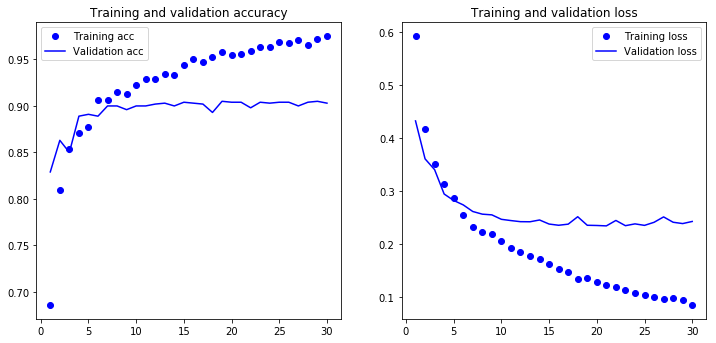

In [23]:
"""
Fast Feature Extraction Without Data Augmentation (2)
"""
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,12))

plt.subplot(221)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(222)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [28]:
"""
Fast Feature Extraction With Data Augmentation (1)

Extending the model you have (conv_base) by adding Dense layers on top, and running the whole thing end to end on the input data.
This will allow you to use data augmentation, because every input image goes through the convolutional base every time it’s seen
by the model. But for the same reason, this technique is far more expensive than the first.
"""
from keras import models
from keras import layers
from keras import optimizers

new_conv_base = VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=(150, 150, 3))

model = models.Sequential()
model.add(new_conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
"""
Fast Feature Extraction With Data Augmentation (2)

Before you compile and train the model, it’s very important to freeze the convolutional base. Freezing a layer or set of layers means
preventing their weights from being updated during training. If you don’t do this, then the representations that were previously learned
by the convolutional base will be modified during training. Because the Dense layers on top are randomly initialized, very large weight
updates would be propagated through the network, effectively destroying the representations previously learned.
"""
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# freeze a network by setting its trainable attribute to False
new_conv_base.trainable = True
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))
new_conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=50,
                              verbose=2)

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 30
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 21s - loss: 0.4311 - acc: 0.7875 - val_loss: 0.1912 - val_acc: 0.9340
Epoch 2/30
 - 19s - loss: 0.2477 - acc: 0.8955 - val_loss: 0.1254 - val_acc: 0.9410
Epoch 3/30
 - 19s - loss: 0.1857 - acc: 0.9210 - val_loss: 0.0972 - val_acc: 0.9580
Epoch 4/30
 - 19s - loss: 0.1583 - acc: 0.9345 - val_loss: 0.1107 - val_acc: 0.9470
Epoch 5/30
 - 19s - loss: 0.1375 - acc: 0.9455 - val_loss: 0.0787 - val_acc: 0.9640
Epoch 6/30
 - 19s - loss: 0.1284 - acc: 0.9425 - val_loss: 0.0930 - val_acc: 0.9660
Epoch 7/30
 - 19s - loss: 0.1204 - acc: 0.9505 - val_loss: 0.1153 - val_acc: 0.9470
Epoch 8/30
 - 19s - loss: 0.0902 - acc: 0.9640 - val_loss: 0.1255 - val_acc: 0.9570
Epoch 9/30
 - 19s - loss: 0.0855 - acc: 0.9630 - val_loss: 0.1417 - val_acc: 0.9540
Epoch 10/30
 

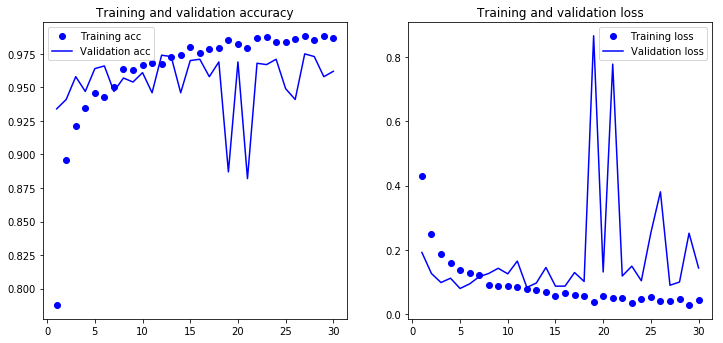

In [32]:
"""
Fast Feature Extraction With Data Augmentation (3)
"""
import matplotlib.pyplot as plt

model.save('model/cats_and_dogs_small_3.h5')

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,12))

plt.subplot(221)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(222)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [33]:
"""
Method 2: Fine-tuning (1)

1. Another widely used technique for model reuse, complementary to feature extraction, is fine-tuning. Fine-tuning consists of unfreezing
   a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model
   (in this case, the fully connected classifier) and these top layers. This is called fine-tuning because it slightly adjusts the more
   abstract representations of the model being reused, in order to make them more relevant for the problem at hand.

2. It’s necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized classifier on top. For the
   same reason, it’s only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been
   trained. If the classifier isn’t already trained, then the error signal propagating through the network during training will be too
   large, and the representations previously learned by the layers being fine-tuned will be destroyed.

3. The steps for fine-tuning a network are as follow:
   -- Add your custom network on top of an already-trained base network.
   -- Freeze the base network.
   -- Train the part you added.
   -- Unfreeze some layers in the base network.
   -- Jointly train both these layers and the part you added.

4. Why not fine-tune more layers? Why not fine-tune the entire convolutional base? You could. But you need to consider the following:
   -- Earlier layers in the convolutional base encode more-generic, reusable features, whereas layers higher up encode more-specialized
      features. It’s more useful to fine-tune the more specialized features, because these are the ones that need to be repurposed
      on your new problem. There would be fast-decreasing returns in fine-tuning lower layers.
   -- The more parameters you’re training, the more you’re at risk of overfitting. The convolutional base has 15 million parameters,
      so it would be risky to attempt to train it on your small dataset.
   -- Thus, in this situation, it’s a good strategy to fine-tune only the top two or three layers in the convolutional base.

5. The reason for using a low learning rate is that you want to limit the magnitude of the modifications you make to the representations
   of the three layers you’re fine-tuning. Updates that are too large may harm these representations.
"""

# You’ll fine-tune the last three convolutional layers, which means all layers up to block4_pool should be frozen, and the layers
# block5_conv1, block5_conv2, and block5_conv3 should be trainable
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
# Fine-tuning the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),  # low learning rate
              metrics=['acc'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=100,
                              validation_data=validation_generator,
                              validation_steps=50)

Epoch 1/100
100/100 [==============================] - 20s 200ms/step - loss: 0.0178 - acc: 0.9935 - val_loss: 0.1512 - val_acc: 0.9710
Epoch 2/100
100/100 [==============================] - 19s 187ms/step - loss: 0.0255 - acc: 0.9935 - val_loss: 0.1345 - val_acc: 0.9740
Epoch 3/100
100/100 [==============================] - 19s 188ms/step - loss: 0.0181 - acc: 0.9945 - val_loss: 0.1872 - val_acc: 0.9670
Epoch 4/100
100/100 [==============================] - 19s 188ms/step - loss: 0.0097 - acc: 0.9980 - val_loss: 0.2772 - val_acc: 0.9520
Epoch 5/100
100/100 [==============================] - 19s 188ms/step - loss: 0.0123 - acc: 0.9950 - val_loss: 0.1940 - val_acc: 0.9700
Epoch 6/100
100/100 [==============================] - 19s 188ms/step - loss: 0.0105 - acc: 0.9965 - val_loss: 0.1305 - val_acc: 0.9740
Epoch 7/100
100/100 [==============================] - 19s 189ms/step - loss: 0.0061 - acc: 0.9980 - val_loss: 0.1739 - val_acc: 0.9750
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 19s 192ms/step - loss: 0.0066 - acc: 0.9975 - val_loss: 0.1823 - val_acc: 0.9770
Epoch 62/100
100/100 [==============================] - 19s 192ms/step - loss: 0.0202 - acc: 0.9960 - val_loss: 0.1831 - val_acc: 0.9670
Epoch 63/100
100/100 [==============================] - 19s 193ms/step - loss: 0.0097 - acc: 0.9980 - val_loss: 0.1667 - val_acc: 0.9720
Epoch 64/100
100/100 [==============================] - 19s 192ms/step - loss: 0.0170 - acc: 0.9965 - val_loss: 0.2316 - val_acc: 0.9660
Epoch 65/100
100/100 [==============================] - 19s 191ms/step - loss: 0.0090 - acc: 0.9985 - val_loss: 0.1402 - val_acc: 0.9780
Epoch 66/100
100/100 [==============================] - 19s 192ms/step - loss: 0.0181 - acc: 0.9960 - val_loss: 0.1486 - val_acc: 0.9700
Epoch 67/100
100/100 [==============================] - 19s 192ms/step - loss: 0.0075 - acc: 0.9980 - val_loss: 0.1565 - val_acc: 0.9730
Epoch 68/100
100/100 [===================

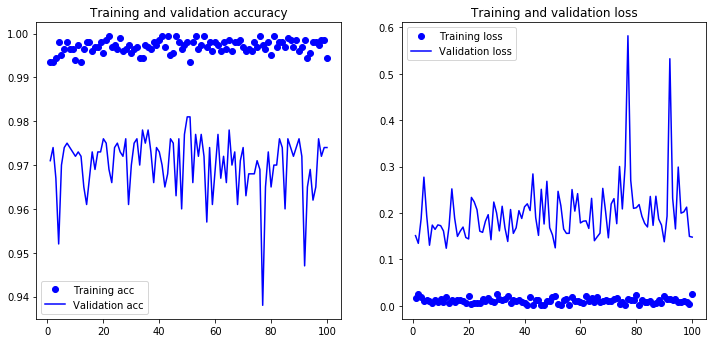

In [34]:
"""
Fine-tuning (2)
"""
import matplotlib.pyplot as plt

model.save('model/cats_and_dogs_small_4.h5')

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,12))

plt.subplot(221)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(222)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

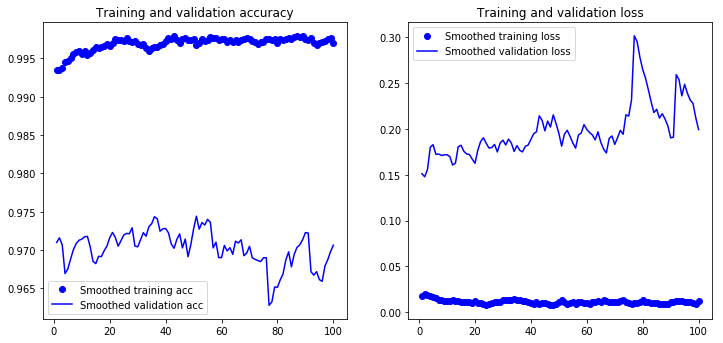

In [35]:
"""
Fine-tuning (3)

These curves look noisy. To make them more readable, you can smooth them by replacing every loss and accuracy with exponential
moving averages of these quantities.
"""
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.figure(figsize=(12,12))

plt.subplot(221)
plt.plot(epochs,smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(222)
plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [36]:
"""
Fine-tuning (4)

How could accuracy stay stable or improve if the loss isn’t decreasing? The answer is simple: what you display is an average of pointwise
loss values; but what matters for accuracy is the distribution of the loss values, not their average, because accuracy is the result of
a binary thresholding of the class probability predicted by the model. The model may still be improving even if this isn’t reflected
in the average loss.
"""

# evaluate
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(150, 150),
                                                  batch_size=20,
                                                  class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9639999949932099


In [ ]:
"""
Summary

1. Convnets are the best type of machine-learning models for computer-vision tasks. It’s possible to train one from scratch even
   on a very small dataset, with decent results.
   
2. On a small dataset, overfitting will be the main issue. Data augmentation is a powerful way to fight overfitting when you’re working
   with image data.

3. It’s easy to reuse an existing convnet on a new dataset via feature extraction. This is a valuable technique for working with small
   image datasets.

4. As a complement to feature extraction, you can use fine-tuning, which adapts to a new problem some of the representations previously
   learned by an existing model. This pushes performance a bit further.
"""
